In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Naman@2004",
                            database = "ecomm")
cur = db.cursor()

# List all unique cities where customers are located. 

In [74]:
query = """select distinct customer_city from ecomm.customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
print(df.head())

                       0
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


# Count the number of orders placed in 2017

In [12]:
query = """select count(order_purchase_timestamp) from ecomm.orders 
where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

# Find the total sales per category

In [72]:
query = """select (products.product_category) pro,
sum(payments.payment_value) sums
from ecommers.products join ecommers.order_items
on products.product_id = order_items.product_id 
join ecommers.payments
on  payments.order_id = order_items.order_id
group by pro """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","sales"])
print(df.head())

               category         sales
0             perfumery  5.067387e+05
1  Furniture Decoration  1.430176e+06
2             telephony  4.868821e+05
3        bed table bath  1.712554e+06
4            automotive  8.522943e+05


# Calculate the percentage of orders that were paid in installments

In [48]:
query = """select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from ecomm.payments"""
cur.execute(query)
data = cur.fetchall()
data

         0
0  99.9981


# Count the number of customers from each state.

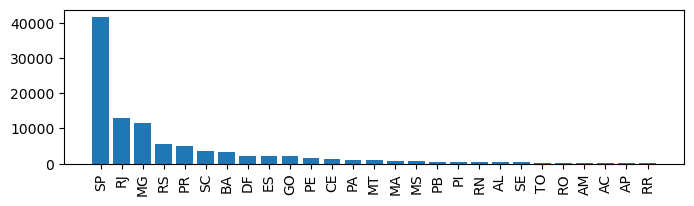

    a      b
0  SP  41746
4  RJ  12852
2  MG  11635
5  RS   5466
3  PR   5045


In [70]:
query = """ select customer_state,count(customer_id) from ecomm.customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["a","b"])
df = df.sort_values(by = "b", ascending = False)
plt.figure(figsize = (8,2))
plt.bar(df["a"],df["b"])
plt.xticks(rotation = 90)
plt.show()
print(df.head())

# Calculate the number of orders per month in 2018

  month name  no_order
0       July      6292
1     August      6512
2   February      6728
3       June      6167
4      March      7211
5    January      7269
6        May      6873
7      April      6939
8  September        16
9    October         4


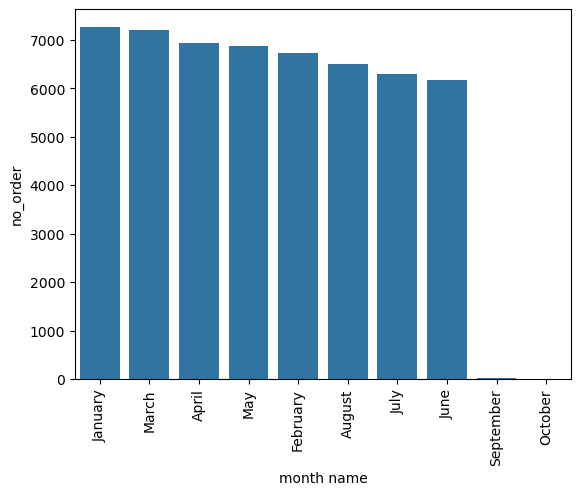

In [10]:
query = """select monthname(order_purchase_timestamp),count(order_id) from ecomm.orders where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp)"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["month name","no_order"])
print(df)
df = df.sort_values(by = "no_order" , ascending = False )
sns.barplot(data = df , x = "month name",y = "no_order" )
plt.xticks(rotation = 90)
plt.show()

# Find the average number of products per order, grouped by customer city

In [14]:
query = """with count_num as
(select orders.order_id,orders.customer_id,(count(order_items.order_id)) as oc from
ecomm.orders join ecomm.order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city , avg(count_num.oc) from
ecomm.customers join count_num
on customers.customer_id = count_num.customer_id
group by customer_city"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["customer_city", "avg_items_per_order"])
df = df.head()
print(df)

         customer_city avg_items_per_order
0            sao paulo              1.1562
1  sao jose dos campos              1.1385
2         porto alegre              1.1749
3              indaial              1.1154
4         treze tilias              1.2727


# Calculate the percentage of total revenue contributed by each product category

               category  avg_revenue
0             perfumery     3.165361
1  Furniture Decoration     8.933649
2             telephony     3.041326
3        bed table bath    10.697529
4            automotive     5.323887


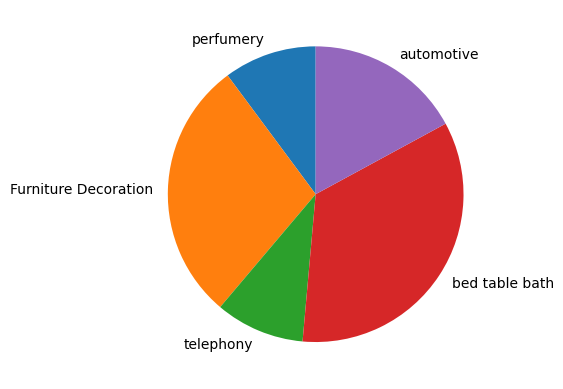

In [16]:
query = """select products.product_category,(sum(payments.payment_value)/(select sum(payment_value) from ecomm.payments))*100
from ecomm.products join ecomm.order_items
on products.product_id = order_items.product_id 
join ecomm.payments
on order_items.order_id = payments.order_id
group by product_category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","avg_revenue"])
df = df.head()
print(df)
plt.pie(df["avg_revenue"],labels = df["category"],startangle = 90)
plt.show()

# Identify the correlation between product price and the number of times a product has been purchased

In [20]:
import numpy as np
query = """select products.product_category , count(products.product_id),
avg(order_items.price)
from ecomm.products join ecomm.order_items
on products.product_id = order_items.product_id
group by product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","count","price"])
a1 = df["count"]
a2 = df["price"]
np.corrcoef([a1,a2])

array([[ 1.        , -0.10631552],
       [-0.10631552,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue

                          seller_id        revenue  rank
0  7c67e1448b00f6e969d365cea6b010ab  507166.907302     1
1  1025f0e2d44d7041d6cf58b6550e0bfa  308222.039840     2
2  4a3ca9315b744ce9f8e9374361493884  301245.269765     3
3  1f50f920176fa81dab994f9023523100  290253.420128     4
4  53243585a1d6dc2643021fd1853d8905  284903.080498     5


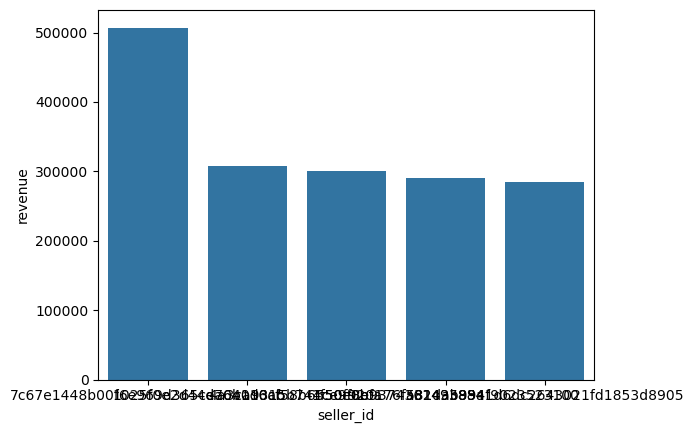

In [23]:
query = """select  order_items.seller_id , sum(payments.payment_value) as revenue, rank() 
over (order by sum(payments.payment_value) desc) as sale_rank
from ecomm.order_items join ecomm.payments 
on order_items.order_id = payments.order_id 
group by order_items.seller_id order by sale_rank"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id" , "revenue","rank"])
print(df.head())
df = df.head()
sns.barplot(data = df , x = "seller_id" , y = "revenue")
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [23]:
query = """select a.customer_id , a.order_purchase_timestamp , avg(a.payment)
over (partition by a.customer_id order by a.order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id , orders.order_purchase_timestamp,payments.payment_value as payment
from ecomm.orders join ecomm.payments
on orders.order_id = payments.order_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_id","time","mov_avg"])
print(df.head())

                        customer_id                 time     mov_avg
0  00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26  114.739998
1  000161a058600d5901f007fab4c27140  2017-07-16 09:40:32   67.410004
2  0001fd6190edaaf884bcaf3d49edf079  2017-02-28 11:06:43  195.419998
3  0002414f95344307404f0ace7a26f1d5  2017-08-16 13:09:20  179.350006
4  000379cdec625522490c315e70c7a9fb  2018-04-02 13:42:17  107.010002


# Calculate the cumulative sales per month for each year.

In [26]:
query = """select a.years,a.months,sum(a.payment) 
over(order by years,months) as pay from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
sum(payments.payment_value) as payment
from ecomm.orders join ecomm.payments
on  orders.order_id = payments.order_id
group  by years,months order by years,months) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","months","cul_prices"])
print(df.head())

   years  months     cul_prices
0   2016       9     252.239994
1   2016      10   59342.719993
2   2016      12   59362.339994
3   2017       1  197850.380058
4   2017       2  489758.389565


# Calculate the year-over-year growth rate of total sales

In [29]:
query = """with a as (select year(orders.order_purchase_timestamp) as years,
sum(payments.payment_value) as payment
from ecomm.orders join ecomm.payments
on orders.order_id = payments.order_id
group by years order by years asc)
select years,((payment-lag(payment) over (order by years)) / lag(payment) over (order by years))*100
from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["year","y-o-y growth"])
print(df)

   year  y-o-y growth
0  2016           NaN
1  2017  12112.703760
2  2018     20.000924


# Identify the top 3 customers who spent the most money in each year.

                        customer_id  year       payment  rank
0  a9dc96b027d1252bbac0a9b72d837fc6  2016   1423.550049     1
1  1d34ed25963d5aae4cf3d7f3a4cda173  2016   1400.739990     2
2  4a06381959b6670756de02e07b83815f  2016   1227.780029     3
3  1617b1357756262bfa56ab541c47bc16  2017  13664.080078     1
4  c6e2731c5b391845f6800c97401a43a9  2017   6929.310059     2
5  3fd6777bbce08a352fddd04e4a7cc8f6  2017   6726.660156     3
6  ec5b2ba62e574342386871631fafd3fc  2018   7274.879883     1
7  f48d464a0baaea338cb25f816991ab1f  2018   6922.209961     2
8  e0a2412720e9ea4f26c1ac985f6a7358  2018   4809.439941     3


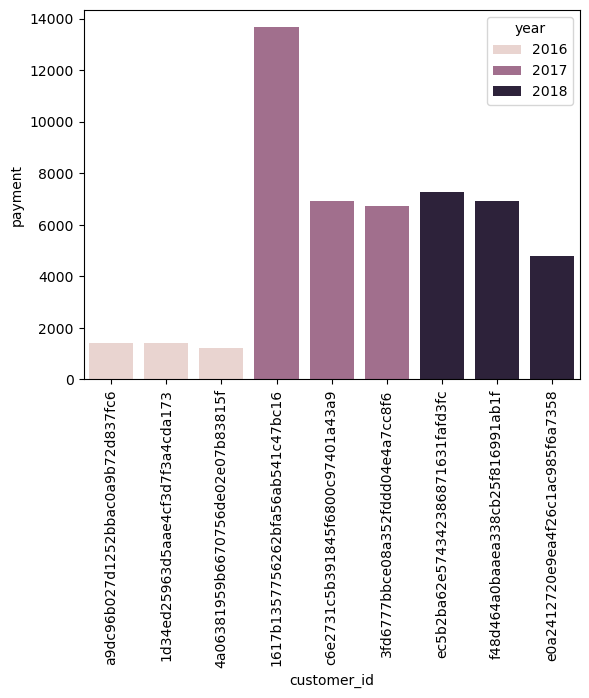

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """select a.customer_id , a.years,a.payment,a.d_rank 
from
(select orders.customer_id , year(orders.order_purchase_timestamp) years, 
sum(payments.payment_value) payment,
rank() over (partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from ecomm.orders join ecomm.payments 
on orders.order_id = payments.order_id
group by orders.customer_id,years order by years,payment desc) as a
where a.d_rank < 4"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data ,columns = ["customer_id","year","payment","rank"])
print(df)
sns.barplot(x = "customer_id",y="payment",data =df,hue = "year")
plt.xticks(rotation = 90)
plt.show()